
<img src = "https://raw.githubusercontent.com/DevoLearn/devolearn/master/images/banner_1.jpg">

## Hello and welcome to devolearn !


### Install from PyPI

In [27]:
devolearn_path = "https://github.com/DevoLearn/devolearn"
install_method = "github"
# Check if devolearn installed
import importlib.util
spec = importlib.util.find_spec("devolearn")
if spec is None:
    if install_method == "pypi":
        !pip install -q devolearn --upgrade
    else:
        !pip install -q git+$devolearn_path
else:
    print(f"devolearn package is already installed :)")

devolearn package is already installed :)


### Clone from Github

In [28]:
## git clone devolearn for sample data
!git clone $devolearn_path

fatal: destination path 'devolearn' already exists and is not an empty directory.


In [29]:
from devolearn import Generator, embryo_generator_model
from devolearn import lineage_population_model
from devolearn import cell_nucleus_segmentor
from devolearn import cell_membrane_segmentor
import torch

import matplotlib.pyplot as plt
import os 
import cv2

## Importing a Pre-Trained model

The first time you'll run the cell below, devolearn will automatically download the latest model weights from GitHub

In [49]:
# Check if GPU is available
try:
    print(torch.tensor([1.0]).cuda())
    cuda_available = True
except RuntimeError:
    cuda_available = False
cuda_available &= torch.cuda.is_available()
device = 'cuda:0' if cuda_available else 'cpu'
print(f"Your device - {device}")

Your device - cpu


In [50]:
model = lineage_population_model(device=device)

## Estimating the lineage-wise population of cells within the C. elegans embryo from a photo  

In [51]:
pred = model.predict(image_path = "devolearn/devolearn/tests/sample_data/images/embryo_sample.png")
print(pred)

{'A': 21, 'E': 2, 'M': 5, 'P': 0, 'C': 4, 'D': 1, 'Z': 0}


## Estimating the same populations from a video file



One can directly save the frame-wise video predictions into a CSV file with `save_csv = True`

In [52]:
if os.path.isdir("sample_preds") is not True:
    os.mkdir("sample_preds")

results = model.predict_from_video(video_path = "devolearn/devolearn/tests/sample_data/videos/embryo_timelapse.mov", 
                                   save_csv = True, 
                                   csv_name = "sample_preds/video_preds.csv", 
                                   ignore_first_n_frames= 10, 
                                   ignore_last_n_frames= 10 
                                   )


Predicting from video file:  ::   1%|▏         | 5/389 [00:00<00:08, 45.99it/s]

skipped possible corrupt frame number :  389


Predicting from video file:  :: 100%|██████████| 389/389 [00:08<00:00, 47.01it/s]


In [53]:
results.tail(5)

,A,E,M,P,C,D,Z
373,228,10,38,1,24,7,2
374,188,8,30,1,20,6,1
375,27,11,43,1,26,8,1
376,232,10,38,1,23,7,2
377,207,8,33,0,21,6,1


##  Generating a population plot directly from a video file 

Predicting from video file:  ::   1%|▏         | 5/389 [00:00<00:07, 48.23it/s]

skipped possible corrupt frame number :  389


Predicting from video file:  :: 100%|██████████| 389/389 [00:08<00:00, 45.79it/s]


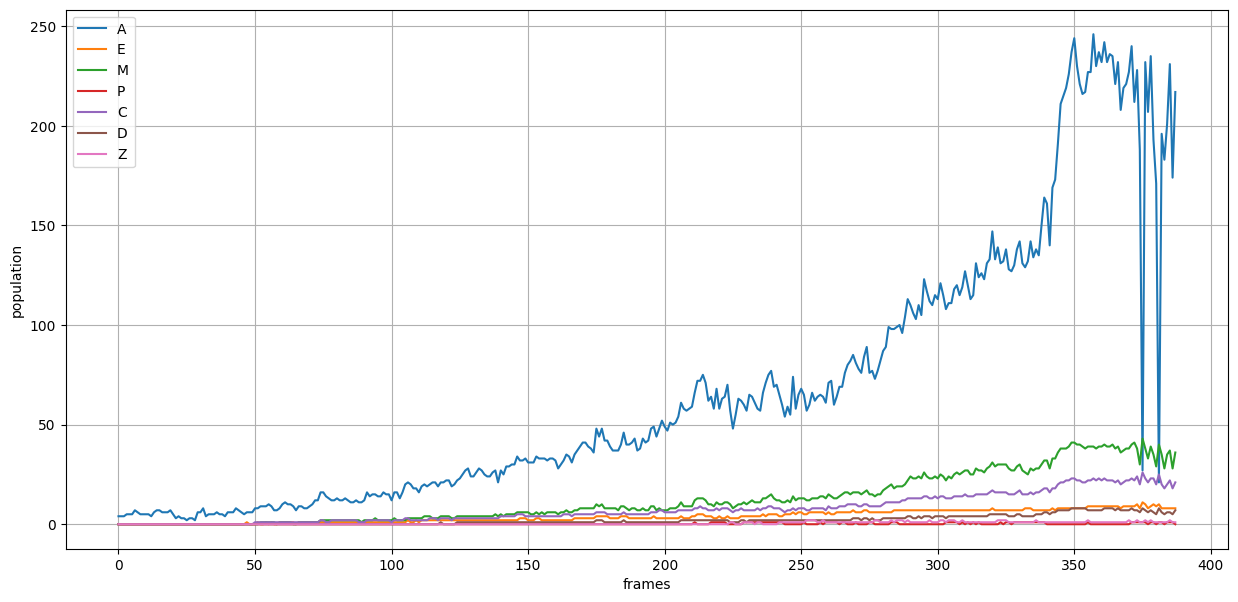

In [54]:
plt.rcParams['figure.figsize'] = 15, 7
                                    
plot = model.create_population_plot_from_video(video_path = "devolearn/devolearn/tests/sample_data/videos/embryo_timelapse.mov", 
                                               save_plot= True, 
                                               plot_name= "sample_preds/plot.jpg", 
                                               ignore_last_n_frames= 0 
                                               )
plot.grid()
plot.show()

## Using the pre-trained GAN to synthetic images of embryos 

In [55]:
generator = embryo_generator_model()

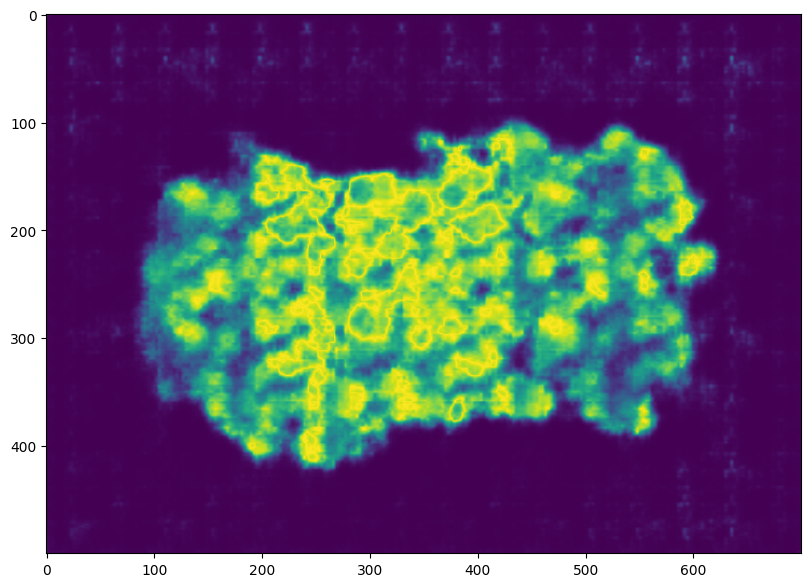

In [56]:
gen_image = generator.generate()  ## returns a 2d numpy array 
plt.imshow(gen_image)
plt.show()

## Bulk generation using the GAN 

All the generated images get saved into the folder `foldername`

generating images :: 100%|██████████| 20/20 [00:00<00:00, 29.92it/s]


Saved  20  images in generated_images


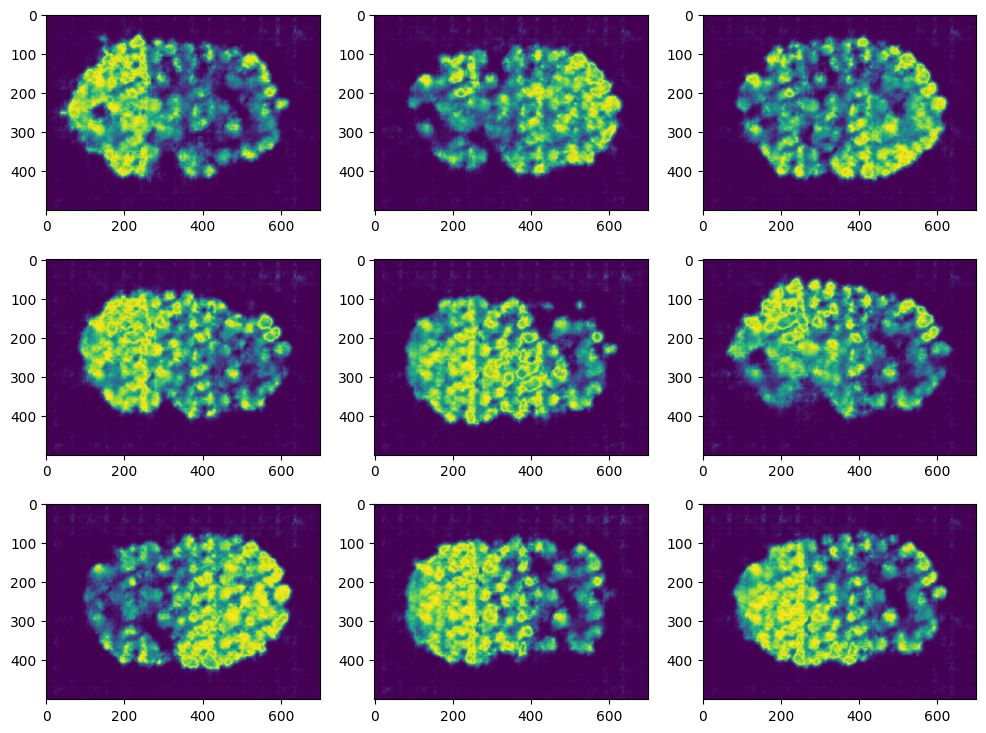

In [57]:
generator.generate_n_images(n = 20, 
                            foldername= "generated_images", 
                            image_size= (700,500)  ## (width,height)
                            )

fig, ax = plt.subplots(3,3, figsize = (12,9))

image_paths = os.listdir("generated_images")
for i in range(9):
    image = cv2.imread("generated_images/" + image_paths[i], 0)
    ax.flat[i].imshow(image)


## Segmenting the C. elegans embryo 

In [58]:
segmentor = cell_membrane_segmentor()

### Segmenting an image 

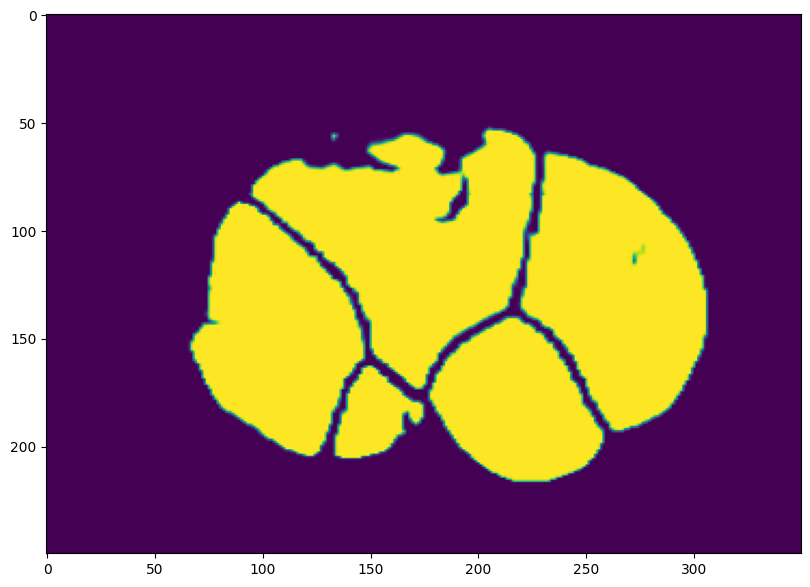

In [59]:
seg_pred = segmentor.predict(image_path = "devolearn/devolearn/tests/sample_data/images/seg_sample.jpg", centroid_mode =False )
plt.imshow(seg_pred)
plt.show()

### Segmenting and extracting the centroids 

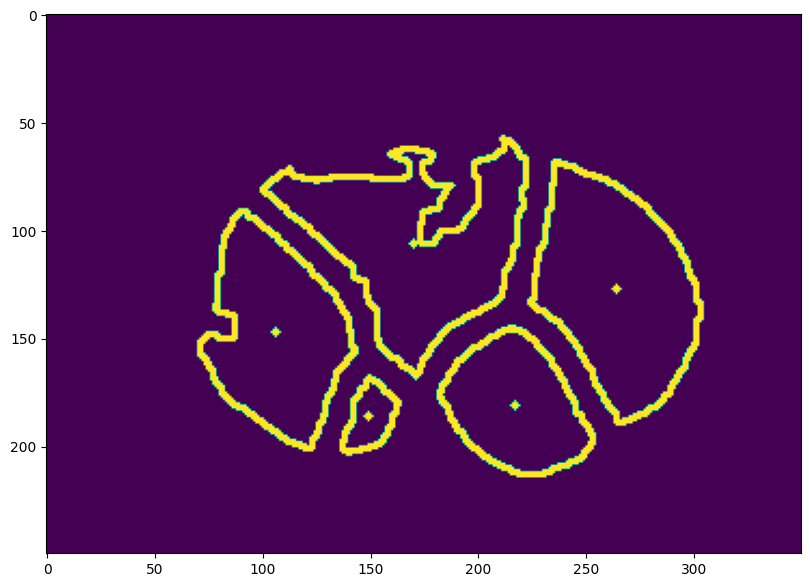

In [60]:
seg_pred, centroids = segmentor.predict(image_path = "devolearn/devolearn/tests/sample_data/images/seg_sample.jpg", centroid_mode = True)
plt.imshow(seg_pred)
plt.show()

# Frame by frame segmentation from video files

All the segmented frames get saved into the folder `save_folder`

In [61]:
filenames = segmentor.predict_from_video(video_path = "devolearn/devolearn/tests/sample_data/videos/seg_sample.mov", 
                                         centroid_mode = False, 
                                         save_folder = "segmented_images"
                                         )

saving predictions: 100%|██████████| 421/421 [00:18<00:00, 22.96it/s]


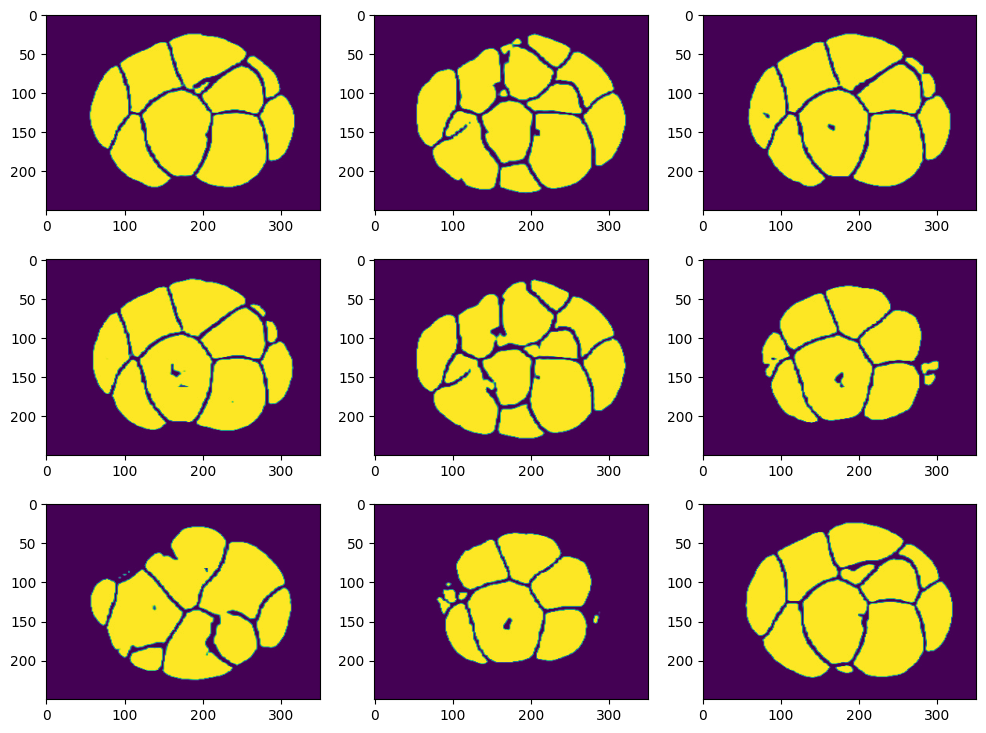

In [62]:
fig, ax = plt.subplots(3,3, figsize = (12,9))

segmented_image_paths = os.listdir("segmented_images")
for i in range(9):
    image = cv2.imread("segmented_images/" + segmented_image_paths[i], 0)
    ax.flat[i].imshow(image)

### Segmenting from a video and saving the centroids into a CSV file 



In [63]:
df = segmentor.predict_from_video(video_path = "devolearn/devolearn/tests/sample_data/videos/seg_sample.mov", 
                                  centroid_mode = True, 
                                  save_folder = "centroid")
df.to_csv("centroids.csv")

saving predictions: 100%|██████████| 421/421 [00:17<00:00, 24.02it/s]


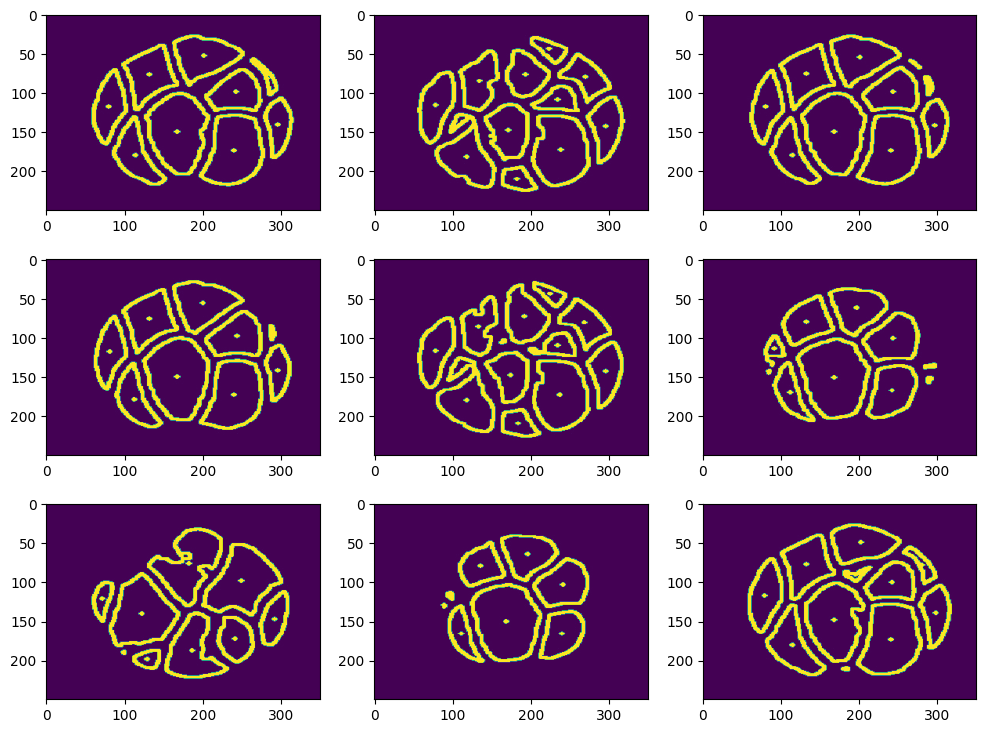

In [64]:
fig, ax = plt.subplots(3,3, figsize = (12,9))

segmented_image_paths = os.listdir("centroid")
for i in range(9):
    image = cv2.imread("centroid/" + segmented_image_paths[i], 0)
    ax.flat[i].imshow(image)

## Run tests (optional)

In [66]:
import devolearn
machine = 'pc'
if machine == 'colab':
    !python /content/devolearn/devolearn/tests/test.py
else:
    !python devolearn/devolearn/tests/test.py

/home/alon/Projects/alon/reserach/data-science-demos/.venv/lib/python3.9/site-packages/devolearn/cell_membrane_segmentor/cell_membrane_segmentor.py:96: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((256,256), interpolation = Image.NEAREST),
/home/alon/Projects/alon/reserach/data-science-demos/.venv/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
saving predictions: 100%|█████████████████████| 421/421 [00:17<00:00, 23.86it/s]
./home/alon/Projects/alon/reserach/data-science-demos/.venv/lib/python3.9/site-packages/devolearn/cell_nucleus_segmentor/cell_nucleus_segmentor.py:60: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE inste